#Player Re-Identification-System

##Installing Dependencies

In [1]:
!pip install torch torchvision torchaudio ultralytics scipy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

###Model Loader Function

In [2]:
from ultralytics import YOLO

def load_yolo_model(file_path):
  model = YOLO(file_path)
  print("Model Loaded Successfully!")
  return model


In [3]:
file_path = '/content/best.pt'
model = load_yolo_model(file_path)

# Checking the class names from the loaded model
print("Model's class names:", model.names)

Model Loaded Successfully!
Model's class names: {0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}


###Video Processing and Frame Extraction

In [4]:
import cv2
import os

# Create folders to store extracted frames
os.makedirs("frames/15sec_input_720p", exist_ok=True)

# Function to extract frames from a video
def extract_frames(video_path, output_folder, frame_interval=30):

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"Video: {video_path} | FPS: {fps}")

    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{saved_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_count += 1
        frame_count += 1

    cap.release()
    print(f"Extracted {saved_count} frames to: {output_folder}")

In [5]:
#Call the function for both videos
extract_frames("/content/15sec_input_720p.mp4", "frames/15sec_input_720p", frame_interval=5)  # captures every 5th frame (Can Put 10 for less compute and faster processing)

Video: /content/15sec_input_720p.mp4 | FPS: 25.0
Extracted 75 frames to: frames/15sec_input_720p


###Player and Ball Detection Function

In [6]:
import os
import cv2

# Detect players and ball in one image
def detect_objects(image_path):
    frame = cv2.imread(image_path)
    results = model(frame)
    detections = []
    for box in results[0].boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        detections.append({
            "bbox": [x1, y1, x2, y2],
            "confidence": conf,
            "class_id": cls
        })
    return detections

In [7]:
import json
import os

def detect_all_frames(frame_folder, output_json):
    output_data = {}
    frame_files = sorted(os.listdir(frame_folder))

    output_dir = os.path.dirname(output_json)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")


    for i, fname in enumerate(frame_files):
        if not fname.endswith(".jpg"): continue
        fpath = os.path.join(frame_folder, fname)
        detections = detect_objects(fpath)
        output_data[fname] = detections
        print(f"[{i+1}/{len(frame_files)}] Processed: {fname} ({len(detections)} detections)")

    # Save detections as JSON
    with open(output_json, "w") as f:
        json.dump(output_data, f, indent=2)
    print(f"\nDetection results saved to: {output_json}")

In [8]:

detect_all_frames("frames/15sec_input_720p", "outputs/15sec_input_720p_detections.json")

Created output directory: outputs

0: 384x640 1 ball, 16 players, 2 referees, 68.9ms
Speed: 15.3ms preprocess, 68.9ms inference, 369.0ms postprocess per image at shape (1, 3, 384, 640)
[1/75] Processed: frame_0000.jpg (19 detections)

0: 384x640 1 ball, 16 players, 2 referees, 60.8ms
Speed: 2.4ms preprocess, 60.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
[2/75] Processed: frame_0001.jpg (19 detections)

0: 384x640 1 ball, 16 players, 2 referees, 60.8ms
Speed: 2.3ms preprocess, 60.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
[3/75] Processed: frame_0002.jpg (19 detections)

0: 384x640 17 players, 2 referees, 60.8ms
Speed: 2.3ms preprocess, 60.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
[4/75] Processed: frame_0003.jpg (19 detections)

0: 384x640 14 players, 1 referee, 45.9ms
Speed: 2.3ms preprocess, 45.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
[5/75] Processed: frame_0004.jpg (15 detecti



###Visualizing Sample Frames

In [9]:
import cv2
import json
import os

def visualize_detections(frame_folder, detection_json, output_folder, class_names=None):
    os.makedirs(output_folder, exist_ok=True)

    # Load detection results
    with open(detection_json, "r") as f:
        detections = json.load(f)

    # Iterate over each frame
    for fname, det_list in detections.items():
        img_path = os.path.join(frame_folder, fname)
        img = cv2.imread(img_path)

        for det in det_list:
            x1, y1, x2, y2 = det["bbox"]
            conf = det["confidence"]
            class_id = det["class_id"]

            label = f"{class_names[class_id] if class_names else class_id} {conf:.2f}"

            # Draw rectangle: Green for player (class_id 2), Red for others
            color = (0, 255, 0) if class_id == 2 else (0, 0, 255)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, label, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Save image with boxes
        out_path = os.path.join(output_folder, fname)
        cv2.imwrite(out_path, img)

    print(f"Saved annotated frames to: {output_folder}")

In [10]:
# Class names as per your model's label order
class_names = ["ball", "goalkeeper", "player", "referee"]

# Visualize for 15sec_input_720p frames
visualize_detections(
    frame_folder="frames/15sec_input_720p",
    detection_json="outputs/15sec_input_720p_detections.json",
    output_folder="outputs/vis_15sec_input_720p",
    class_names=class_names
)


Saved annotated frames to: outputs/vis_15sec_input_720p


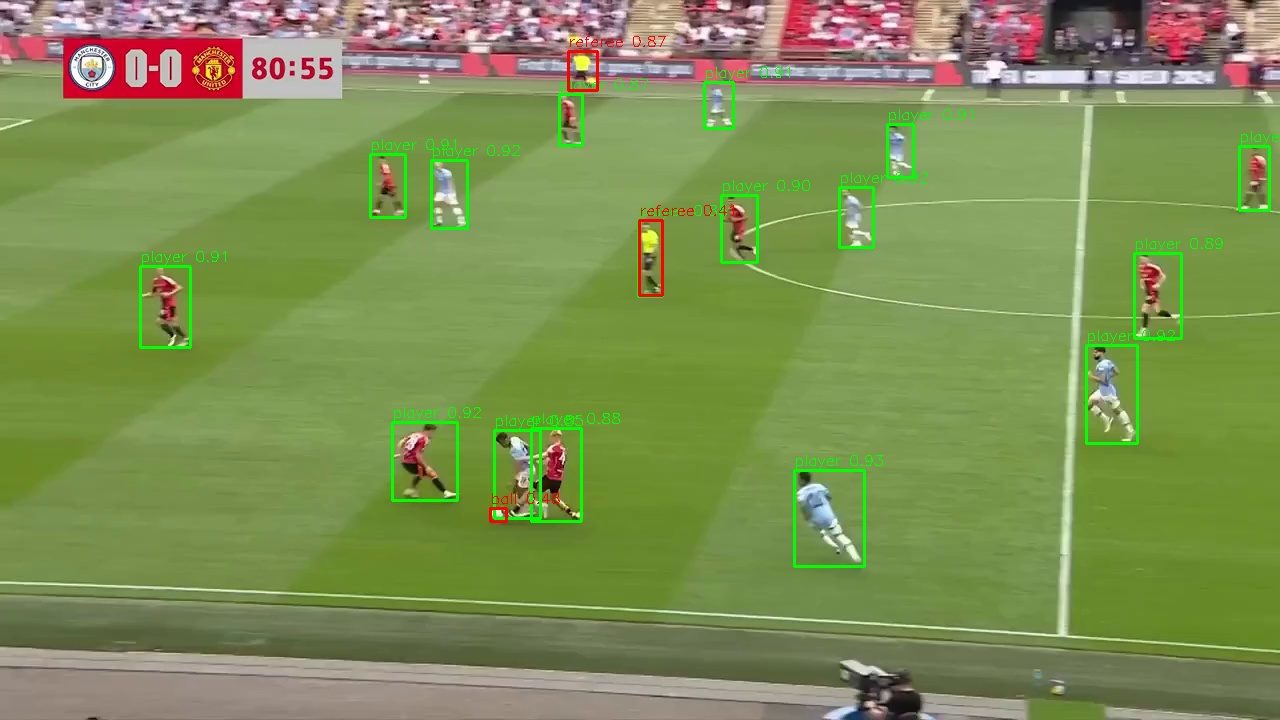

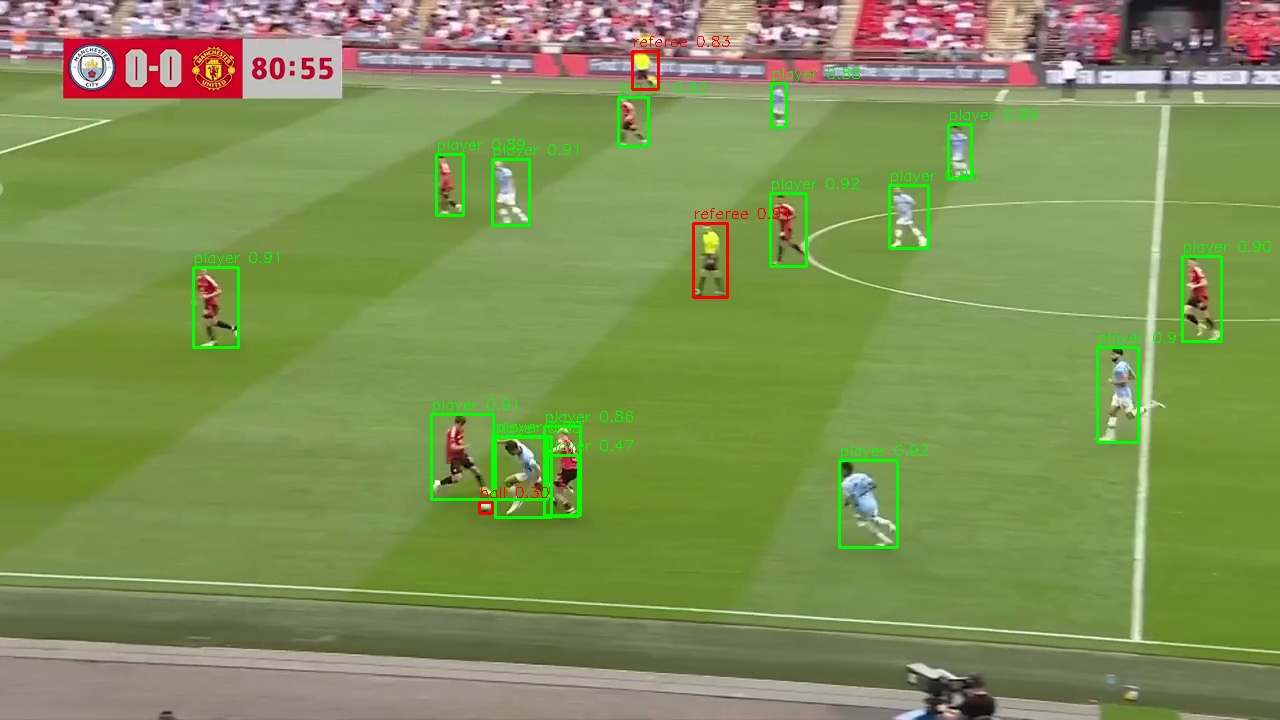

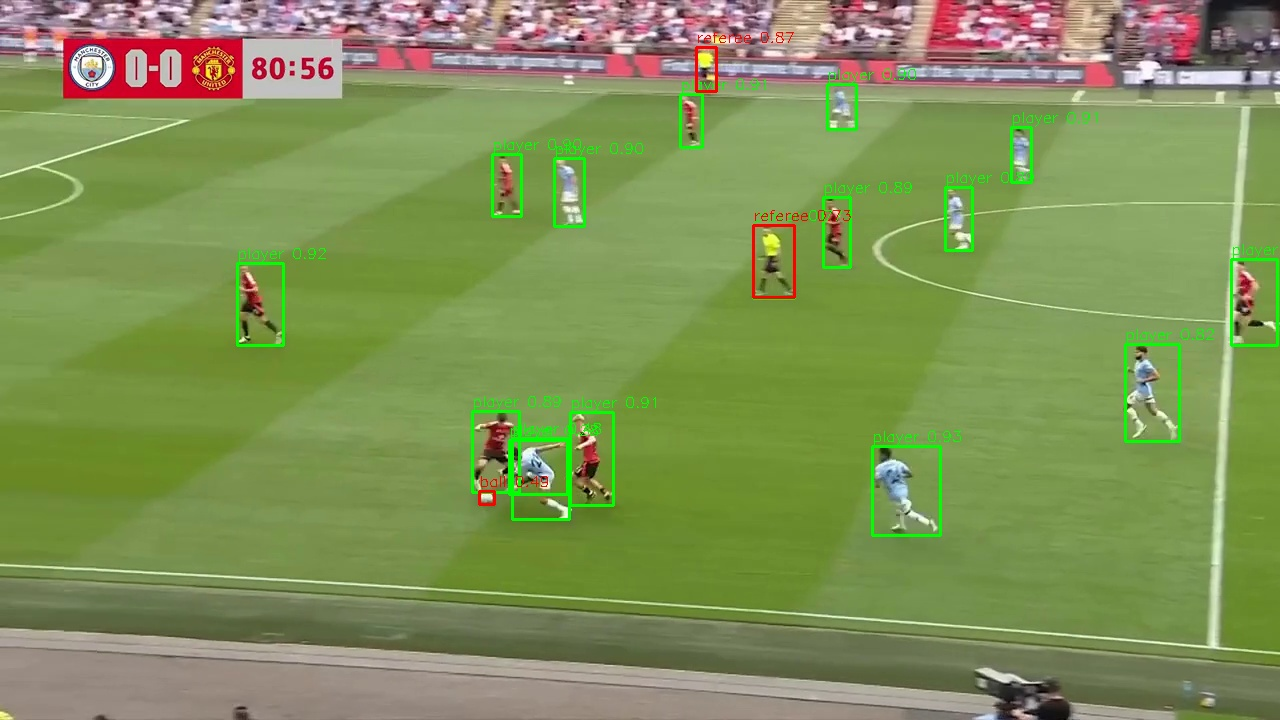

In [11]:
from IPython.display import Image, display

def show_sample_images(folder, count=3):
    files = sorted([f for f in os.listdir(folder) if f.endswith(".jpg")])
    for fname in files[:count]:
        display(Image(filename=os.path.join(folder, fname)))

# Show some visualized frames
show_sample_images("outputs/vis_15sec_input_720p")

###Reconstructing Video from Annotated Frames

In [12]:
import cv2
import os

def frames_to_video(frame_folder, output_video_path, fps=30):
    frame_files = sorted([f for f in os.listdir(frame_folder) if f.endswith(".jpg")])
    if not frame_files:
        print(" No frames found.")
        return

    # Read first frame to get dimensions
    first_frame = cv2.imread(os.path.join(frame_folder, frame_files[0]))
    height, width, _ = first_frame.shape

    # Define video writer
    out = cv2.VideoWriter(
        output_video_path,
        cv2.VideoWriter_fourcc(*'mp4v'),
        fps,
        (width, height)
    )

    for fname in frame_files:
        frame_path = os.path.join(frame_folder, fname)
        frame = cv2.imread(frame_path)
        out.write(frame)

    out.release()
    print(f"Video saved: {output_video_path}")

In [13]:
# For broadcast visualization
frames_to_video("outputs/vis_15sec_input_720p", "outputs/vis_15sec_input_720p.mp4", fps=5)

Video saved: outputs/vis_15sec_input_720p.mp4


###Re-Identification System

In [17]:
!git clone https://github.com/KaiyangZhou/deep-person-reid.git
%cd deep-person-reid
!pip install -e .
%cd ..

Cloning into 'deep-person-reid'...
remote: Enumerating objects: 9876, done.
remote: Counting objects: 100% (826/826), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 9876 (delta 746), reused 717 (delta 717), pack-reused 9050 (from 1)
Receiving objects: 100% (9876/9876), 9.53 MiB | 7.69 MiB/s, done.
Resolving deltas: 100% (7314/7314), done.
/content/deep-person-reid
Obtaining file:///content/deep-person-reid
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: torchreid
    Found existing

/content


In [5]:
!pip install deep-sort-realtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 106.4 MB/s eta 0:00:00


In [6]:
from deep_sort_realtime.deepsort_tracker import DeepSort

tracker = DeepSort(
    max_age=30,
    n_init=3,
    nms_max_overlap=1.0,
    embedder="torchreid",
    half=True,
    bgr=True,
    embedder_gpu=True
)


/content/deep-person-reid/torchreid/utils/tools.py:43: UserWarning: No file found at "/usr/local/lib/python3.11/dist-packages/deep_sort_realtime/embedder/weights/osnet_ain_ms_d_c_wtsonly.pth"
  warnings.warn('No file found at "{}"'.format(fpath))


Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_ain_x1_0
- params: 2,193,616
- flops: 978,878,352


In [10]:
import cv2
import numpy as np
from torchreid.utils import FeatureExtractor
from scipy.spatial.distance import cdist
from collections import defaultdict
from tqdm import tqdm

# ----------- CONFIGURATION -----------
video_path = '15sec_input_720p.mp4'
output_path = 'output_reid_re_entry.mp4'
PLAYER_CLASS_IDX = 2  # YOLO class index for 'player'
CONF_THRESH = 0.5
SIM_THRESHOLD = 0.4 # Lower = stricter matching
GALLERY_MAXLEN = 35  # Number of features to keep per ID



extractor = FeatureExtractor(
    model_name='osnet_x1_0', #OSNet with Attention
    device='cuda'
)

gallery = defaultdict(list)
next_id = 0

def get_reid_feature(crop):
    crop = cv2.resize(crop, (128, 256))  # Torchreid expects (256,128)
    feat = extractor([crop])
    if hasattr(feat, 'cpu'):
        feat = feat.cpu().numpy()
    return feat[0] if feat.ndim == 2 else feat

def match_to_gallery(feat, gallery, threshold=SIM_THRESHOLD, used_pids=None):
    if not gallery:
        return None
    all_ids, all_feats = [], []
    for pid, feats in gallery.items():
        if used_pids is not None and pid in used_pids:
            continue
        all_ids.extend([pid]*len(feats))
        all_feats.extend(feats)
    if not all_feats:
        return None
    all_feats = np.vstack(all_feats)
    dists = cdist([feat], all_feats, metric='cosine')[0]
    min_idx = np.argmin(dists)
    if dists[min_idx] < threshold:
        return all_ids[min_idx]
    return None

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

trackid2pid = {}

for frame_idx in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    # --- Detection step (custom YOLO) ---
    results = model(frame)
    detections = []
    crops = []
    boxes_xywh = []
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            if cls == PLAYER_CLASS_IDX and conf > CONF_THRESH:
                detections.append(([x1, y1, x2 - x1, y2 - y1], conf, 'player'))
                crops.append(frame[y1:y2, x1:x2])
                boxes_xywh.append([x1, y1, x2, y2])

    # --- Tracking step ---
    tracks = tracker.update_tracks(detections, frame=frame)

    used_pids = set()

    # --- Assign persistent IDs and draw ---
    for i, track in enumerate(tracks):
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        ltrb = track.to_ltrb()
        found = False
        for j, box in enumerate(boxes_xywh):
            bx1, by1, bx2, by2 = box
            # Simple overlap check
            if abs(ltrb[0]-bx1)<10 and abs(ltrb[1]-by1)<10 and abs(ltrb[2]-bx2)<10 and abs(ltrb[3]-by2)<10:
                crop = crops[j]
                feat = get_reid_feature(crop)
                # Assign persistent ID, ensuring uniqueness in this frame
                if track_id not in trackid2pid:
                    matched_pid = match_to_gallery(feat, gallery, used_pids=used_pids)
                    if matched_pid is not None:
                        persistent_id = matched_pid
                    else:
                        persistent_id = next_id
                        next_id += 1
                    gallery[persistent_id].append(feat)
                    if len(gallery[persistent_id]) > GALLERY_MAXLEN:
                        gallery[persistent_id] = gallery[persistent_id][-GALLERY_MAXLEN:]
                    trackid2pid[track_id] = persistent_id
                else:
                    persistent_id = trackid2pid[track_id]
                    gallery[persistent_id].append(feat)
                    if len(gallery[persistent_id]) > GALLERY_MAXLEN:
                        gallery[persistent_id] = gallery[persistent_id][-GALLERY_MAXLEN:]
                used_pids.add(persistent_id)
                # Draw only persistent ID
                cv2.rectangle(frame, (bx1, by1), (bx2, by2), (0,255,0), 2)
                cv2.putText(frame, f'ID: {persistent_id}', (bx1, by1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
                found = True
                break


    out.write(frame)

cap.release()
out.release()
print(f"Saved persistent re-ID video to {output_path}")


Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352


  0%|          | 0/375 [00:00<?, ?it/s]


0: 384x640 1 ball, 16 players, 2 referees, 66.0ms
Speed: 3.4ms preprocess, 66.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  0%|          | 1/375 [00:00<02:09,  2.89it/s]


0: 384x640 18 players, 2 referees, 54.7ms
Speed: 3.1ms preprocess, 54.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 2/375 [00:00<01:58,  3.15it/s]


0: 384x640 1 ball, 16 players, 2 referees, 54.7ms
Speed: 3.4ms preprocess, 54.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 3/375 [00:01<02:42,  2.29it/s]


0: 384x640 1 ball, 14 players, 2 referees, 49.1ms
Speed: 2.5ms preprocess, 49.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 4/375 [00:01<02:48,  2.20it/s]


0: 384x640 1 ball, 14 players, 2 referees, 49.1ms
Speed: 2.0ms preprocess, 49.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  1%|▏         | 5/375 [00:02<02:39,  2.32it/s]


0: 384x640 1 ball, 16 players, 2 referees, 42.1ms
Speed: 2.2ms preprocess, 42.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 6/375 [00:02<02:37,  2.35it/s]


0: 384x640 15 players, 2 referees, 42.2ms
Speed: 3.5ms preprocess, 42.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 7/375 [00:02<02:37,  2.34it/s]


0: 384x640 15 players, 1 referee, 41.4ms
Speed: 2.3ms preprocess, 41.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 8/375 [00:03<02:30,  2.44it/s]


0: 384x640 1 ball, 16 players, 1 referee, 39.0ms
Speed: 2.3ms preprocess, 39.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 9/375 [00:03<02:31,  2.41it/s]


0: 384x640 1 ball, 15 players, 2 referees, 39.1ms
Speed: 2.4ms preprocess, 39.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 10/375 [00:04<02:29,  2.44it/s]


0: 384x640 1 ball, 15 players, 2 referees, 39.1ms
Speed: 2.3ms preprocess, 39.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 11/375 [00:04<02:26,  2.48it/s]


0: 384x640 1 ball, 15 players, 2 referees, 39.1ms
Speed: 2.7ms preprocess, 39.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 12/375 [00:05<02:39,  2.27it/s]


0: 384x640 1 ball, 13 players, 2 referees, 44.0ms
Speed: 2.3ms preprocess, 44.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 13/375 [00:05<02:43,  2.21it/s]


0: 384x640 14 players, 2 referees, 45.8ms
Speed: 2.3ms preprocess, 45.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  4%|▎         | 14/375 [00:05<02:44,  2.20it/s]


0: 384x640 14 players, 2 referees, 44.3ms
Speed: 2.2ms preprocess, 44.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 15/375 [00:06<02:45,  2.18it/s]


0: 384x640 19 players, 2 referees, 44.2ms
Speed: 2.1ms preprocess, 44.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 16/375 [00:07<03:00,  1.99it/s]


0: 384x640 14 players, 2 referees, 44.3ms
Speed: 2.2ms preprocess, 44.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 17/375 [00:07<02:45,  2.16it/s]


0: 384x640 15 players, 2 referees, 45.0ms
Speed: 2.3ms preprocess, 45.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 18/375 [00:07<02:43,  2.18it/s]


0: 384x640 15 players, 2 referees, 49.3ms
Speed: 2.2ms preprocess, 49.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 19/375 [00:08<02:40,  2.22it/s]


0: 384x640 15 players, 2 referees, 44.3ms
Speed: 1.9ms preprocess, 44.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 20/375 [00:08<02:30,  2.35it/s]


0: 384x640 14 players, 1 referee, 42.2ms
Speed: 2.7ms preprocess, 42.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 21/375 [00:09<02:30,  2.36it/s]


0: 384x640 14 players, 4 referees, 42.2ms
Speed: 2.2ms preprocess, 42.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 22/375 [00:09<02:22,  2.47it/s]


0: 384x640 14 players, 3 referees, 41.4ms
Speed: 2.7ms preprocess, 41.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 23/375 [00:09<02:20,  2.51it/s]


0: 384x640 14 players, 3 referees, 41.4ms
Speed: 2.4ms preprocess, 41.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  6%|▋         | 24/375 [00:10<02:18,  2.53it/s]


0: 384x640 14 players, 2 referees, 41.3ms
Speed: 2.7ms preprocess, 41.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 25/375 [00:10<02:15,  2.58it/s]


0: 384x640 14 players, 3 referees, 41.3ms
Speed: 2.4ms preprocess, 41.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 26/375 [00:10<02:13,  2.61it/s]


0: 384x640 14 players, 3 referees, 41.4ms
Speed: 2.9ms preprocess, 41.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 27/375 [00:11<02:05,  2.77it/s]


0: 384x640 1 ball, 13 players, 2 referees, 40.5ms
Speed: 2.8ms preprocess, 40.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 28/375 [00:11<02:01,  2.86it/s]


0: 384x640 2 balls, 13 players, 2 referees, 40.6ms
Speed: 2.1ms preprocess, 40.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 29/375 [00:11<02:00,  2.88it/s]


0: 384x640 2 balls, 16 players, 2 referees, 40.5ms
Speed: 1.9ms preprocess, 40.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 30/375 [00:12<02:03,  2.80it/s]


0: 384x640 2 balls, 15 players, 2 referees, 40.5ms
Speed: 2.0ms preprocess, 40.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 31/375 [00:12<02:01,  2.83it/s]


0: 384x640 1 ball, 14 players, 2 referees, 39.9ms
Speed: 2.9ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  9%|▊         | 32/375 [00:12<01:56,  2.96it/s]


0: 384x640 1 ball, 14 players, 2 referees, 40.1ms
Speed: 2.7ms preprocess, 40.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 33/375 [00:13<01:56,  2.93it/s]


0: 384x640 15 players, 2 referees, 39.8ms
Speed: 2.9ms preprocess, 39.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 34/375 [00:13<01:58,  2.89it/s]


0: 384x640 14 players, 3 referees, 39.9ms
Speed: 3.1ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 35/375 [00:14<01:56,  2.93it/s]


0: 384x640 13 players, 3 referees, 39.9ms
Speed: 2.7ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 36/375 [00:14<01:58,  2.86it/s]


0: 384x640 1 ball, 15 players, 2 referees, 42.4ms
Speed: 2.3ms preprocess, 42.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 37/375 [00:14<02:04,  2.72it/s]


0: 384x640 1 ball, 16 players, 2 referees, 40.8ms
Speed: 3.8ms preprocess, 40.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 38/375 [00:15<02:04,  2.70it/s]


0: 384x640 1 ball, 16 players, 2 referees, 39.8ms
Speed: 2.3ms preprocess, 39.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 39/375 [00:15<02:00,  2.78it/s]


0: 384x640 1 ball, 18 players, 3 referees, 39.9ms
Speed: 2.3ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 40/375 [00:16<02:19,  2.41it/s]


0: 384x640 1 ball, 17 players, 3 referees, 39.6ms
Speed: 1.9ms preprocess, 39.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 41/375 [00:16<02:29,  2.23it/s]


0: 384x640 16 players, 3 referees, 39.7ms
Speed: 2.2ms preprocess, 39.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 42/375 [00:17<02:43,  2.04it/s]


0: 384x640 14 players, 2 referees, 45.1ms
Speed: 2.5ms preprocess, 45.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 11%|█▏        | 43/375 [00:17<02:42,  2.04it/s]


0: 384x640 1 ball, 17 players, 2 referees, 46.7ms
Speed: 2.3ms preprocess, 46.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 44/375 [00:18<03:07,  1.76it/s]


0: 384x640 1 ball, 18 players, 2 referees, 55.0ms
Speed: 2.3ms preprocess, 55.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 45/375 [00:19<03:23,  1.63it/s]


0: 384x640 1 ball, 17 players, 2 referees, 52.9ms
Speed: 2.2ms preprocess, 52.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 46/375 [00:19<03:14,  1.69it/s]


0: 384x640 16 players, 3 referees, 47.5ms
Speed: 2.4ms preprocess, 47.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 47/375 [00:20<02:53,  1.89it/s]


0: 384x640 1 ball, 17 players, 2 referees, 47.5ms
Speed: 2.1ms preprocess, 47.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 48/375 [00:20<02:43,  2.00it/s]


0: 384x640 1 ball, 16 players, 2 referees, 47.5ms
Speed: 2.3ms preprocess, 47.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 49/375 [00:20<02:39,  2.04it/s]


0: 384x640 16 players, 3 referees, 47.6ms
Speed: 2.3ms preprocess, 47.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 50/375 [00:21<02:31,  2.14it/s]


0: 384x640 16 players, 2 referees, 43.0ms
Speed: 2.3ms preprocess, 43.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▎        | 51/375 [00:21<02:35,  2.09it/s]


0: 384x640 17 players, 3 referees, 43.0ms
Speed: 3.3ms preprocess, 43.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 52/375 [00:22<02:40,  2.01it/s]


0: 384x640 14 players, 3 referees, 42.9ms
Speed: 2.0ms preprocess, 42.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 53/375 [00:22<02:39,  2.01it/s]


0: 384x640 16 players, 3 referees, 41.9ms
Speed: 1.9ms preprocess, 41.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 54/375 [00:23<02:41,  1.99it/s]


0: 384x640 14 players, 4 referees, 41.9ms
Speed: 2.4ms preprocess, 41.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 55/375 [00:23<02:34,  2.07it/s]


0: 384x640 17 players, 2 referees, 41.1ms
Speed: 2.0ms preprocess, 41.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 56/375 [00:24<02:25,  2.19it/s]


0: 384x640 13 players, 2 referees, 41.1ms
Speed: 1.9ms preprocess, 41.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 57/375 [00:24<02:20,  2.26it/s]


0: 384x640 13 players, 2 referees, 40.4ms
Speed: 2.3ms preprocess, 40.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 58/375 [00:25<02:26,  2.17it/s]


0: 384x640 15 players, 2 referees, 40.2ms
Speed: 2.3ms preprocess, 40.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 59/375 [00:25<02:30,  2.11it/s]


0: 384x640 15 players, 2 referees, 40.3ms
Speed: 2.6ms preprocess, 40.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 60/375 [00:26<02:26,  2.15it/s]


0: 384x640 1 ball, 14 players, 2 referees, 39.8ms
Speed: 2.0ms preprocess, 39.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▋        | 61/375 [00:26<02:22,  2.21it/s]


0: 384x640 1 ball, 15 players, 2 referees, 47.8ms
Speed: 2.4ms preprocess, 47.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 62/375 [00:27<02:24,  2.17it/s]


0: 384x640 1 ball, 15 players, 2 referees, 50.4ms
Speed: 1.9ms preprocess, 50.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 63/375 [00:27<02:30,  2.08it/s]


0: 384x640 14 players, 2 referees, 45.2ms
Speed: 2.3ms preprocess, 45.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 64/375 [00:27<02:26,  2.12it/s]


0: 384x640 1 ball, 14 players, 3 referees, 45.1ms
Speed: 3.1ms preprocess, 45.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 65/375 [00:28<02:27,  2.11it/s]


0: 384x640 1 ball, 16 players, 4 referees, 45.2ms
Speed: 2.4ms preprocess, 45.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 66/375 [00:28<02:23,  2.15it/s]


0: 384x640 1 ball, 14 players, 3 referees, 45.2ms
Speed: 2.2ms preprocess, 45.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 67/375 [00:29<02:19,  2.21it/s]


0: 384x640 1 ball, 14 players, 4 referees, 48.6ms
Speed: 2.3ms preprocess, 48.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 68/375 [00:30<02:39,  1.92it/s]


0: 384x640 1 ball, 14 players, 2 referees, 55.3ms
Speed: 2.3ms preprocess, 55.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 69/375 [00:30<02:58,  1.71it/s]


0: 384x640 1 ball, 15 players, 2 referees, 47.9ms
Speed: 2.2ms preprocess, 47.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▊        | 70/375 [00:31<03:02,  1.67it/s]


0: 384x640 1 ball, 14 players, 2 referees, 47.9ms
Speed: 2.3ms preprocess, 47.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 71/375 [00:31<03:03,  1.66it/s]


0: 384x640 1 ball, 14 players, 2 referees, 54.6ms
Speed: 2.2ms preprocess, 54.6ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 72/375 [00:32<02:42,  1.86it/s]


0: 384x640 1 ball, 15 players, 2 referees, 45.3ms
Speed: 1.8ms preprocess, 45.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 73/375 [00:32<02:42,  1.86it/s]


0: 384x640 1 ball, 16 players, 2 referees, 45.5ms
Speed: 2.4ms preprocess, 45.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 74/375 [00:33<02:40,  1.87it/s]


0: 384x640 1 ball, 15 players, 2 referees, 45.4ms
Speed: 3.2ms preprocess, 45.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 20%|██        | 75/375 [00:33<02:30,  2.00it/s]


0: 384x640 1 ball, 15 players, 2 referees, 41.4ms
Speed: 2.7ms preprocess, 41.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 20%|██        | 76/375 [00:34<02:35,  1.93it/s]


0: 384x640 1 ball, 15 players, 2 referees, 40.5ms
Speed: 3.0ms preprocess, 40.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 77/375 [00:34<02:24,  2.07it/s]


0: 384x640 1 ball, 17 players, 1 referee, 40.5ms
Speed: 2.2ms preprocess, 40.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 78/375 [00:35<02:18,  2.14it/s]


0: 384x640 17 players, 2 referees, 39.1ms
Speed: 2.3ms preprocess, 39.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 79/375 [00:35<02:15,  2.19it/s]


0: 384x640 1 ball, 17 players, 2 referees, 39.2ms
Speed: 2.8ms preprocess, 39.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 21%|██▏       | 80/375 [00:36<02:12,  2.23it/s]


0: 384x640 1 ball, 14 players, 2 referees, 38.3ms
Speed: 2.3ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 81/375 [00:36<02:07,  2.31it/s]


0: 384x640 15 players, 2 referees, 38.3ms
Speed: 2.1ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 82/375 [00:36<02:03,  2.38it/s]


0: 384x640 14 players, 2 referees, 38.4ms
Speed: 2.4ms preprocess, 38.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 83/375 [00:37<02:11,  2.21it/s]


0: 384x640 14 players, 2 referees, 38.4ms
Speed: 2.4ms preprocess, 38.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 84/375 [00:37<02:17,  2.11it/s]


0: 384x640 1 ball, 14 players, 2 referees, 45.2ms
Speed: 2.7ms preprocess, 45.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 85/375 [00:38<02:20,  2.06it/s]


0: 384x640 14 players, 2 referees, 49.5ms
Speed: 2.0ms preprocess, 49.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 86/375 [00:38<02:16,  2.12it/s]


0: 384x640 1 ball, 14 players, 2 referees, 43.2ms
Speed: 2.3ms preprocess, 43.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 87/375 [00:39<02:11,  2.20it/s]


0: 384x640 1 ball, 15 players, 2 referees, 41.4ms
Speed: 2.3ms preprocess, 41.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 88/375 [00:39<02:15,  2.12it/s]


0: 384x640 1 ball, 17 players, 2 referees, 41.4ms
Speed: 2.7ms preprocess, 41.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▎       | 89/375 [00:40<02:15,  2.10it/s]


0: 384x640 1 ball, 16 players, 2 referees, 41.4ms
Speed: 2.4ms preprocess, 41.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 90/375 [00:40<02:19,  2.05it/s]


0: 384x640 1 ball, 16 players, 1 referee, 47.5ms
Speed: 2.0ms preprocess, 47.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 91/375 [00:41<02:13,  2.13it/s]


0: 384x640 1 ball, 18 players, 3 referees, 42.0ms
Speed: 2.4ms preprocess, 42.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 92/375 [00:41<02:31,  1.87it/s]


0: 384x640 1 ball, 17 players, 2 referees, 41.2ms
Speed: 2.2ms preprocess, 41.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 93/375 [00:42<02:48,  1.68it/s]


0: 384x640 1 ball, 18 players, 2 referees, 41.1ms
Speed: 2.3ms preprocess, 41.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▌       | 94/375 [00:43<02:49,  1.66it/s]


0: 384x640 1 ball, 18 players, 2 referees, 46.0ms
Speed: 2.3ms preprocess, 46.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▌       | 95/375 [00:43<02:55,  1.60it/s]


0: 384x640 1 ball, 16 players, 2 referees, 51.0ms
Speed: 2.6ms preprocess, 51.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 96/375 [00:44<02:51,  1.63it/s]


0: 384x640 1 ball, 16 players, 2 referees, 54.6ms
Speed: 2.4ms preprocess, 54.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 97/375 [00:45<02:37,  1.76it/s]


0: 384x640 1 ball, 18 players, 2 referees, 57.5ms
Speed: 2.5ms preprocess, 57.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 98/375 [00:45<02:36,  1.77it/s]


0: 384x640 1 ball, 19 players, 3 referees, 48.6ms
Speed: 2.4ms preprocess, 48.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▋       | 99/375 [00:46<02:23,  1.93it/s]


0: 384x640 1 ball, 16 players, 2 referees, 48.5ms
Speed: 2.3ms preprocess, 48.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 100/375 [00:46<02:23,  1.91it/s]


0: 384x640 1 ball, 17 players, 2 referees, 48.5ms
Speed: 4.7ms preprocess, 48.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 101/375 [00:47<02:23,  1.91it/s]


0: 384x640 1 ball, 17 players, 1 referee, 53.7ms
Speed: 2.5ms preprocess, 53.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 102/375 [00:47<02:17,  1.98it/s]


0: 384x640 1 ball, 17 players, 2 referees, 44.0ms
Speed: 2.1ms preprocess, 44.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 103/375 [00:47<02:12,  2.05it/s]


0: 384x640 1 ball, 16 players, 2 referees, 43.2ms
Speed: 2.4ms preprocess, 43.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 104/375 [00:48<02:17,  1.98it/s]


0: 384x640 1 ball, 17 players, 2 referees, 43.2ms
Speed: 2.1ms preprocess, 43.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 105/375 [00:48<02:12,  2.04it/s]


0: 384x640 1 ball, 17 players, 2 referees, 39.6ms
Speed: 2.2ms preprocess, 39.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 106/375 [00:49<02:09,  2.07it/s]


0: 384x640 1 ball, 19 players, 2 referees, 39.6ms
Speed: 2.0ms preprocess, 39.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▊       | 107/375 [00:49<02:10,  2.06it/s]


0: 384x640 1 ball, 15 players, 1 referee, 40.2ms
Speed: 5.1ms preprocess, 40.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 108/375 [00:50<02:07,  2.09it/s]


0: 384x640 16 players, 39.6ms
Speed: 5.1ms preprocess, 39.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 109/375 [00:50<02:15,  1.97it/s]


0: 384x640 1 ball, 16 players, 46.3ms
Speed: 2.4ms preprocess, 46.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 110/375 [00:51<02:17,  1.93it/s]


0: 384x640 2 balls, 17 players, 49.6ms
Speed: 2.3ms preprocess, 49.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 30%|██▉       | 111/375 [00:52<02:21,  1.86it/s]


0: 384x640 17 players, 1 referee, 43.7ms
Speed: 2.3ms preprocess, 43.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 30%|██▉       | 112/375 [00:52<02:20,  1.88it/s]


0: 384x640 19 players, 1 referee, 43.7ms
Speed: 2.4ms preprocess, 43.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 113/375 [00:53<02:13,  1.96it/s]


0: 384x640 1 ball, 15 players, 2 referees, 43.8ms
Speed: 2.5ms preprocess, 43.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 114/375 [00:53<02:12,  1.97it/s]


0: 384x640 16 players, 1 referee, 48.5ms
Speed: 2.0ms preprocess, 48.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 115/375 [00:54<02:21,  1.84it/s]


0: 384x640 15 players, 1 referee, 53.0ms
Speed: 2.5ms preprocess, 53.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 116/375 [00:55<02:41,  1.60it/s]


0: 384x640 1 ball, 16 players, 1 referee, 62.3ms
Speed: 2.3ms preprocess, 62.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 117/375 [00:55<02:55,  1.47it/s]


0: 384x640 16 players, 1 referee, 66.0ms
Speed: 2.5ms preprocess, 66.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 31%|███▏      | 118/375 [00:56<02:51,  1.50it/s]


0: 384x640 1 ball, 17 players, 1 referee, 65.9ms
Speed: 2.4ms preprocess, 65.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 119/375 [00:57<02:43,  1.57it/s]


0: 384x640 14 players, 1 referee, 51.3ms
Speed: 2.3ms preprocess, 51.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 120/375 [00:57<02:34,  1.65it/s]


0: 384x640 1 ball, 14 players, 1 referee, 51.3ms
Speed: 3.0ms preprocess, 51.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 121/375 [00:58<02:29,  1.70it/s]


0: 384x640 1 ball, 15 players, 1 referee, 43.0ms
Speed: 2.3ms preprocess, 43.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 122/375 [00:58<02:16,  1.86it/s]


0: 384x640 1 ball, 16 players, 1 referee, 42.0ms
Speed: 2.7ms preprocess, 42.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 123/375 [00:59<02:10,  1.93it/s]


0: 384x640 16 players, 1 referee, 40.5ms
Speed: 2.2ms preprocess, 40.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 124/375 [00:59<02:12,  1.90it/s]


0: 384x640 14 players, 1 referee, 40.5ms
Speed: 2.2ms preprocess, 40.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 125/375 [00:59<02:01,  2.05it/s]


0: 384x640 16 players, 2 referees, 40.6ms
Speed: 2.3ms preprocess, 40.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▎      | 126/375 [01:00<02:04,  2.01it/s]


0: 384x640 15 players, 1 referee, 44.5ms
Speed: 1.9ms preprocess, 44.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 127/375 [01:00<01:59,  2.08it/s]


0: 384x640 15 players, 1 referee, 47.6ms
Speed: 2.5ms preprocess, 47.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 128/375 [01:01<01:59,  2.06it/s]


0: 384x640 1 ball, 15 players, 1 referee, 49.1ms
Speed: 2.1ms preprocess, 49.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 129/375 [01:01<01:53,  2.17it/s]


0: 384x640 1 ball, 14 players, 1 referee, 50.6ms
Speed: 2.5ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 130/375 [01:02<01:52,  2.18it/s]


0: 384x640 1 ball, 15 players, 1 referee, 52.1ms
Speed: 2.2ms preprocess, 52.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 131/375 [01:02<01:55,  2.12it/s]


0: 384x640 1 ball, 15 players, 1 referee, 56.1ms
Speed: 3.1ms preprocess, 56.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 132/375 [01:03<01:54,  2.11it/s]


0: 384x640 2 balls, 18 players, 1 referee, 44.9ms
Speed: 2.6ms preprocess, 44.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 133/375 [01:03<01:52,  2.15it/s]


0: 384x640 1 ball, 15 players, 1 referee, 44.8ms
Speed: 2.7ms preprocess, 44.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 134/375 [01:04<01:55,  2.08it/s]


0: 384x640 1 ball, 16 players, 1 referee, 44.8ms
Speed: 3.3ms preprocess, 44.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 135/375 [01:04<01:51,  2.15it/s]


0: 384x640 15 players, 1 referee, 44.2ms
Speed: 1.9ms preprocess, 44.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▋      | 136/375 [01:05<01:52,  2.13it/s]


0: 384x640 1 ball, 16 players, 1 referee, 51.3ms
Speed: 2.1ms preprocess, 51.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 137/375 [01:05<01:56,  2.04it/s]


0: 384x640 1 ball, 14 players, 1 referee, 49.2ms
Speed: 2.5ms preprocess, 49.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 138/375 [01:06<01:52,  2.11it/s]


0: 384x640 1 ball, 18 players, 1 referee, 49.2ms
Speed: 2.5ms preprocess, 49.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 139/375 [01:06<02:04,  1.90it/s]


0: 384x640 14 players, 1 referee, 49.2ms
Speed: 2.3ms preprocess, 49.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 140/375 [01:07<02:19,  1.68it/s]


0: 384x640 16 players, 1 referee, 58.9ms
Speed: 2.2ms preprocess, 58.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 141/375 [01:08<02:35,  1.50it/s]


0: 384x640 16 players, 1 referee, 56.5ms
Speed: 3.4ms preprocess, 56.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 142/375 [01:09<02:37,  1.48it/s]


0: 384x640 15 players, 1 referee, 50.3ms
Speed: 2.1ms preprocess, 50.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 143/375 [01:09<02:29,  1.56it/s]


0: 384x640 15 players, 1 referee, 42.7ms
Speed: 5.8ms preprocess, 42.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 144/375 [01:09<02:09,  1.78it/s]


0: 384x640 1 ball, 13 players, 1 referee, 42.7ms
Speed: 2.0ms preprocess, 42.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▊      | 145/375 [01:10<01:58,  1.93it/s]


0: 384x640 1 ball, 14 players, 2 referees, 42.6ms
Speed: 2.0ms preprocess, 42.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 146/375 [01:10<01:52,  2.04it/s]


0: 384x640 1 ball, 15 players, 1 referee, 42.7ms
Speed: 2.2ms preprocess, 42.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 147/375 [01:11<01:50,  2.07it/s]


0: 384x640 1 ball, 14 players, 1 referee, 45.5ms
Speed: 2.1ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 148/375 [01:11<01:50,  2.05it/s]


0: 384x640 13 players, 1 referee, 49.9ms
Speed: 2.3ms preprocess, 49.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 149/375 [01:12<01:42,  2.21it/s]


0: 384x640 1 ball, 14 players, 1 referee, 44.3ms
Speed: 2.3ms preprocess, 44.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 40%|████      | 150/375 [01:12<01:44,  2.14it/s]


0: 384x640 1 ball, 13 players, 1 referee, 44.3ms
Speed: 2.6ms preprocess, 44.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 40%|████      | 151/375 [01:13<01:40,  2.23it/s]


0: 384x640 1 ball, 14 players, 1 referee, 44.3ms
Speed: 2.6ms preprocess, 44.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 152/375 [01:13<01:36,  2.31it/s]


0: 384x640 1 ball, 13 players, 1 referee, 44.3ms
Speed: 2.5ms preprocess, 44.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 153/375 [01:13<01:41,  2.19it/s]


0: 384x640 1 ball, 13 players, 1 referee, 40.5ms
Speed: 2.1ms preprocess, 40.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 154/375 [01:14<01:42,  2.15it/s]


0: 384x640 1 ball, 14 players, 1 referee, 40.5ms
Speed: 3.0ms preprocess, 40.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 41%|████▏     | 155/375 [01:14<01:45,  2.09it/s]


0: 384x640 13 players, 1 referee, 40.5ms
Speed: 2.5ms preprocess, 40.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 156/375 [01:15<01:41,  2.16it/s]


0: 384x640 1 ball, 12 players, 1 referee, 46.0ms
Speed: 2.3ms preprocess, 46.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 157/375 [01:15<01:43,  2.11it/s]


0: 384x640 1 ball, 12 players, 1 referee, 47.5ms
Speed: 2.2ms preprocess, 47.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 158/375 [01:16<01:43,  2.09it/s]


0: 384x640 12 players, 1 referee, 52.1ms
Speed: 2.3ms preprocess, 52.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 159/375 [01:16<01:39,  2.16it/s]


0: 384x640 14 players, 1 referee, 47.9ms
Speed: 3.4ms preprocess, 47.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 160/375 [01:17<01:40,  2.15it/s]


0: 384x640 15 players, 1 referee, 47.9ms
Speed: 2.2ms preprocess, 47.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 161/375 [01:17<01:43,  2.06it/s]


0: 384x640 13 players, 1 referee, 43.7ms
Speed: 2.5ms preprocess, 43.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 162/375 [01:18<01:38,  2.17it/s]


0: 384x640 12 players, 1 referee, 43.8ms
Speed: 2.5ms preprocess, 43.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 163/375 [01:18<01:33,  2.28it/s]


0: 384x640 12 players, 1 referee, 43.8ms
Speed: 2.4ms preprocess, 43.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▎     | 164/375 [01:19<01:45,  2.01it/s]


0: 384x640 12 players, 1 referee, 52.0ms
Speed: 2.7ms preprocess, 52.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 165/375 [01:19<01:43,  2.02it/s]


0: 384x640 12 players, 1 referee, 48.5ms
Speed: 2.3ms preprocess, 48.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 166/375 [01:20<01:44,  1.99it/s]


0: 384x640 12 players, 1 referee, 48.6ms
Speed: 2.7ms preprocess, 48.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 167/375 [01:20<01:45,  1.97it/s]


0: 384x640 1 ball, 13 players, 48.5ms
Speed: 2.5ms preprocess, 48.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 168/375 [01:21<01:53,  1.83it/s]


0: 384x640 1 ball, 13 players, 59.6ms
Speed: 2.2ms preprocess, 59.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 169/375 [01:21<01:42,  2.01it/s]


0: 384x640 1 ball, 13 players, 47.6ms
Speed: 2.5ms preprocess, 47.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 170/375 [01:22<01:36,  2.13it/s]


0: 384x640 16 players, 1 referee, 45.2ms
Speed: 2.3ms preprocess, 45.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 171/375 [01:22<01:32,  2.19it/s]


0: 384x640 13 players, 1 referee, 45.1ms
Speed: 2.1ms preprocess, 45.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 172/375 [01:23<01:33,  2.16it/s]


0: 384x640 13 players, 1 referee, 45.2ms
Speed: 2.3ms preprocess, 45.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 173/375 [01:23<01:34,  2.13it/s]


0: 384x640 13 players, 1 referee, 43.1ms
Speed: 3.2ms preprocess, 43.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▋     | 174/375 [01:24<01:35,  2.10it/s]


0: 384x640 15 players, 42.7ms
Speed: 2.5ms preprocess, 42.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 175/375 [01:24<01:40,  1.99it/s]


0: 384x640 14 players, 42.6ms
Speed: 3.4ms preprocess, 42.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 176/375 [01:25<01:41,  1.95it/s]


0: 384x640 1 ball, 14 players, 49.2ms
Speed: 2.3ms preprocess, 49.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 177/375 [01:25<01:35,  2.06it/s]


0: 384x640 13 players, 51.3ms
Speed: 2.3ms preprocess, 51.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 178/375 [01:26<01:32,  2.13it/s]


0: 384x640 13 players, 1 referee, 54.6ms
Speed: 6.9ms preprocess, 54.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 179/375 [01:26<01:28,  2.22it/s]


0: 384x640 2 balls, 11 players, 1 referee, 47.9ms
Speed: 2.6ms preprocess, 47.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 180/375 [01:26<01:29,  2.18it/s]


0: 384x640 15 players, 1 referee, 47.8ms
Speed: 2.6ms preprocess, 47.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 181/375 [01:27<01:28,  2.19it/s]


0: 384x640 12 players, 1 referee, 42.6ms
Speed: 2.3ms preprocess, 42.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▊     | 182/375 [01:27<01:29,  2.16it/s]


0: 384x640 1 ball, 12 players, 1 referee, 42.7ms
Speed: 3.7ms preprocess, 42.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 183/375 [01:28<01:26,  2.23it/s]


0: 384x640 14 players, 1 referee, 42.1ms
Speed: 2.2ms preprocess, 42.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 184/375 [01:28<01:29,  2.14it/s]


0: 384x640 12 players, 42.1ms
Speed: 2.2ms preprocess, 42.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 185/375 [01:29<01:26,  2.19it/s]


0: 384x640 12 players, 46.8ms
Speed: 2.1ms preprocess, 46.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 186/375 [01:29<01:28,  2.15it/s]


0: 384x640 1 ball, 12 players, 51.3ms
Speed: 2.2ms preprocess, 51.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 187/375 [01:30<01:22,  2.29it/s]


0: 384x640 1 ball, 12 players, 1 referee, 45.2ms
Speed: 2.0ms preprocess, 45.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 188/375 [01:30<01:24,  2.20it/s]


0: 384x640 12 players, 1 referee, 45.1ms
Speed: 3.8ms preprocess, 45.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 189/375 [01:30<01:21,  2.28it/s]


0: 384x640 1 ball, 11 players, 1 referee, 43.0ms
Speed: 2.5ms preprocess, 43.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 190/375 [01:31<01:15,  2.45it/s]


0: 384x640 1 ball, 12 players, 1 referee, 42.0ms
Speed: 2.3ms preprocess, 42.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 191/375 [01:31<01:20,  2.29it/s]


0: 384x640 1 ball, 12 players, 41.9ms
Speed: 2.3ms preprocess, 41.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 192/375 [01:32<01:28,  2.07it/s]


0: 384x640 1 ball, 15 players, 41.9ms
Speed: 2.2ms preprocess, 41.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████▏    | 193/375 [01:32<01:30,  2.01it/s]


0: 384x640 2 balls, 14 players, 53.5ms
Speed: 3.0ms preprocess, 53.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 194/375 [01:33<01:40,  1.81it/s]


0: 384x640 14 players, 48.5ms
Speed: 5.3ms preprocess, 48.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 195/375 [01:34<01:39,  1.81it/s]


0: 384x640 13 players, 48.5ms
Speed: 2.0ms preprocess, 48.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 196/375 [01:34<01:34,  1.90it/s]


0: 384x640 18 players, 44.0ms
Speed: 2.4ms preprocess, 44.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 197/375 [01:35<01:30,  1.98it/s]


0: 384x640 14 players, 44.0ms
Speed: 2.2ms preprocess, 44.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 198/375 [01:35<01:29,  1.98it/s]


0: 384x640 1 ball, 17 players, 44.0ms
Speed: 3.3ms preprocess, 44.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 199/375 [01:35<01:23,  2.12it/s]


0: 384x640 16 players, 42.7ms
Speed: 2.1ms preprocess, 42.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 200/375 [01:36<01:19,  2.22it/s]


0: 384x640 1 ball, 14 players, 39.9ms
Speed: 2.3ms preprocess, 39.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▎    | 201/375 [01:36<01:24,  2.05it/s]


0: 384x640 1 ball, 17 players, 39.5ms
Speed: 2.2ms preprocess, 39.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 202/375 [01:37<01:16,  2.25it/s]


0: 384x640 1 ball, 15 players, 39.1ms
Speed: 2.6ms preprocess, 39.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 203/375 [01:37<01:19,  2.16it/s]


0: 384x640 1 ball, 14 players, 39.1ms
Speed: 2.7ms preprocess, 39.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 204/375 [01:38<01:15,  2.28it/s]


0: 384x640 2 balls, 13 players, 39.1ms
Speed: 2.2ms preprocess, 39.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 205/375 [01:38<01:15,  2.26it/s]


0: 384x640 14 players, 43.0ms
Speed: 2.2ms preprocess, 43.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 206/375 [01:39<01:12,  2.33it/s]


0: 384x640 14 players, 45.2ms
Speed: 2.2ms preprocess, 45.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 207/375 [01:39<01:10,  2.37it/s]


0: 384x640 13 players, 46.7ms
Speed: 2.9ms preprocess, 46.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 208/375 [01:39<01:14,  2.25it/s]


0: 384x640 1 ball, 15 players, 51.3ms
Speed: 2.2ms preprocess, 51.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 209/375 [01:40<01:11,  2.32it/s]


0: 384x640 1 ball, 13 players, 45.3ms
Speed: 3.2ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 210/375 [01:40<01:09,  2.39it/s]


0: 384x640 13 players, 43.2ms
Speed: 2.7ms preprocess, 43.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▋    | 211/375 [01:41<01:05,  2.49it/s]


0: 384x640 12 players, 43.1ms
Speed: 1.8ms preprocess, 43.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 212/375 [01:41<01:03,  2.57it/s]


0: 384x640 1 ball, 12 players, 43.2ms
Speed: 2.2ms preprocess, 43.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 213/375 [01:41<01:00,  2.68it/s]


0: 384x640 1 ball, 12 players, 43.2ms
Speed: 2.4ms preprocess, 43.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 214/375 [01:42<00:57,  2.81it/s]


0: 384x640 2 balls, 10 players, 43.2ms
Speed: 2.4ms preprocess, 43.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 215/375 [01:42<00:58,  2.75it/s]


0: 384x640 1 ball, 11 players, 46.9ms
Speed: 2.4ms preprocess, 46.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 216/375 [01:42<00:54,  2.90it/s]


0: 384x640 1 ball, 15 players, 48.4ms
Speed: 2.2ms preprocess, 48.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 217/375 [01:43<00:58,  2.71it/s]


0: 384x640 11 players, 43.8ms
Speed: 2.4ms preprocess, 43.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 218/375 [01:43<00:58,  2.66it/s]


0: 384x640 10 players, 43.0ms
Speed: 2.7ms preprocess, 43.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 219/375 [01:43<00:57,  2.72it/s]


0: 384x640 12 players, 43.0ms
Speed: 2.3ms preprocess, 43.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▊    | 220/375 [01:44<01:04,  2.39it/s]


0: 384x640 9 players, 42.9ms
Speed: 2.3ms preprocess, 42.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 221/375 [01:44<01:08,  2.26it/s]


0: 384x640 8 players, 42.9ms
Speed: 5.1ms preprocess, 42.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 222/375 [01:45<01:02,  2.44it/s]


0: 384x640 8 players, 48.7ms
Speed: 2.5ms preprocess, 48.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 223/375 [01:45<01:06,  2.29it/s]


0: 384x640 10 players, 52.5ms
Speed: 2.4ms preprocess, 52.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 224/375 [01:46<01:10,  2.15it/s]


0: 384x640 1 ball, 10 players, 49.9ms
Speed: 2.6ms preprocess, 49.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 225/375 [01:46<01:09,  2.17it/s]


0: 384x640 1 ball, 9 players, 50.0ms
Speed: 3.2ms preprocess, 50.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 226/375 [01:47<01:06,  2.25it/s]


0: 384x640 2 balls, 9 players, 47.9ms
Speed: 2.6ms preprocess, 47.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 227/375 [01:47<00:59,  2.48it/s]


0: 384x640 1 ball, 1 goalkeeper, 8 players, 47.2ms
Speed: 2.3ms preprocess, 47.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 228/375 [01:47<00:53,  2.73it/s]


0: 384x640 1 ball, 1 goalkeeper, 9 players, 47.3ms
Speed: 2.8ms preprocess, 47.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 229/375 [01:48<00:51,  2.81it/s]


0: 384x640 2 balls, 1 goalkeeper, 11 players, 47.2ms
Speed: 2.3ms preprocess, 47.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████▏   | 230/375 [01:48<00:51,  2.80it/s]


0: 384x640 1 ball, 1 goalkeeper, 13 players, 47.2ms
Speed: 2.7ms preprocess, 47.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 231/375 [01:48<00:51,  2.78it/s]


0: 384x640 1 ball, 1 goalkeeper, 12 players, 47.3ms
Speed: 2.5ms preprocess, 47.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 232/375 [01:49<00:59,  2.41it/s]


0: 384x640 1 ball, 1 goalkeeper, 10 players, 46.0ms
Speed: 2.3ms preprocess, 46.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 233/375 [01:49<01:02,  2.25it/s]


0: 384x640 3 balls, 8 players, 46.1ms
Speed: 2.6ms preprocess, 46.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 234/375 [01:50<00:55,  2.56it/s]


0: 384x640 1 goalkeeper, 8 players, 46.1ms
Speed: 2.6ms preprocess, 46.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 235/375 [01:50<00:53,  2.60it/s]


0: 384x640 11 players, 46.0ms
Speed: 2.7ms preprocess, 46.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 236/375 [01:50<00:56,  2.45it/s]


0: 384x640 1 ball, 11 players, 55.4ms
Speed: 2.8ms preprocess, 55.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 237/375 [01:51<00:52,  2.62it/s]


0: 384x640 1 ball, 9 players, 49.2ms
Speed: 2.5ms preprocess, 49.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 238/375 [01:51<00:55,  2.48it/s]


0: 384x640 1 ball, 1 goalkeeper, 11 players, 49.2ms
Speed: 2.6ms preprocess, 49.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▎   | 239/375 [01:52<00:55,  2.44it/s]


0: 384x640 1 ball, 1 goalkeeper, 9 players, 49.2ms
Speed: 2.3ms preprocess, 49.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 240/375 [01:52<00:54,  2.49it/s]


0: 384x640 1 ball, 1 goalkeeper, 8 players, 49.2ms
Speed: 2.6ms preprocess, 49.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 241/375 [01:52<00:49,  2.71it/s]


0: 384x640 1 goalkeeper, 7 players, 47.9ms
Speed: 2.1ms preprocess, 47.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 242/375 [01:53<00:48,  2.76it/s]


0: 384x640 1 goalkeeper, 7 players, 47.9ms
Speed: 2.6ms preprocess, 47.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 243/375 [01:53<00:46,  2.87it/s]


0: 384x640 1 goalkeeper, 9 players, 47.2ms
Speed: 2.4ms preprocess, 47.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 244/375 [01:53<00:42,  3.08it/s]


0: 384x640 1 goalkeeper, 8 players, 47.2ms
Speed: 2.9ms preprocess, 47.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 245/375 [01:54<00:42,  3.08it/s]


0: 384x640 2 balls, 1 goalkeeper, 9 players, 47.2ms
Speed: 2.3ms preprocess, 47.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 246/375 [01:54<00:39,  3.26it/s]


0: 384x640 1 goalkeeper, 8 players, 47.2ms
Speed: 2.8ms preprocess, 47.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 247/375 [01:54<00:44,  2.85it/s]


0: 384x640 1 ball, 1 goalkeeper, 9 players, 47.1ms
Speed: 2.0ms preprocess, 47.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 248/375 [01:55<00:45,  2.82it/s]


0: 384x640 1 ball, 1 goalkeeper, 11 players, 47.0ms
Speed: 1.9ms preprocess, 47.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▋   | 249/375 [01:55<00:49,  2.57it/s]


0: 384x640 1 ball, 1 goalkeeper, 10 players, 46.4ms
Speed: 2.7ms preprocess, 46.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 250/375 [01:56<00:49,  2.54it/s]


0: 384x640 2 balls, 1 goalkeeper, 9 players, 46.4ms
Speed: 2.6ms preprocess, 46.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 251/375 [01:56<00:50,  2.47it/s]


0: 384x640 1 ball, 1 goalkeeper, 9 players, 46.4ms
Speed: 2.3ms preprocess, 46.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 252/375 [01:57<00:54,  2.25it/s]


0: 384x640 1 goalkeeper, 10 players, 55.0ms
Speed: 2.3ms preprocess, 55.0ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 253/375 [01:57<00:56,  2.16it/s]


0: 384x640 10 players, 49.9ms
Speed: 2.5ms preprocess, 49.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 254/375 [01:58<00:56,  2.13it/s]


0: 384x640 10 players, 49.9ms
Speed: 2.5ms preprocess, 49.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 255/375 [01:58<00:58,  2.05it/s]


0: 384x640 11 players, 50.9ms
Speed: 2.8ms preprocess, 50.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 256/375 [01:59<00:57,  2.07it/s]


0: 384x640 1 goalkeeper, 12 players, 56.3ms
Speed: 2.3ms preprocess, 56.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▊   | 257/375 [01:59<00:53,  2.20it/s]


0: 384x640 1 goalkeeper, 10 players, 47.9ms
Speed: 2.3ms preprocess, 47.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 258/375 [01:59<00:54,  2.16it/s]


0: 384x640 1 goalkeeper, 10 players, 47.9ms
Speed: 2.2ms preprocess, 47.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 259/375 [02:00<00:49,  2.36it/s]


0: 384x640 1 goalkeeper, 11 players, 47.9ms
Speed: 2.3ms preprocess, 47.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 260/375 [02:00<00:45,  2.54it/s]


0: 384x640 1 goalkeeper, 9 players, 47.9ms
Speed: 4.0ms preprocess, 47.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 261/375 [02:00<00:45,  2.53it/s]


0: 384x640 1 goalkeeper, 8 players, 49.3ms
Speed: 2.2ms preprocess, 49.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 262/375 [02:01<00:44,  2.54it/s]


0: 384x640 1 goalkeeper, 9 players, 53.4ms
Speed: 2.3ms preprocess, 53.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 263/375 [02:01<00:44,  2.53it/s]


0: 384x640 1 goalkeeper, 9 players, 56.0ms
Speed: 2.5ms preprocess, 56.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 264/375 [02:02<00:40,  2.73it/s]


0: 384x640 1 goalkeeper, 9 players, 56.5ms
Speed: 1.8ms preprocess, 56.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 265/375 [02:02<00:38,  2.85it/s]


0: 384x640 12 players, 48.5ms
Speed: 2.2ms preprocess, 48.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 266/375 [02:02<00:40,  2.72it/s]


0: 384x640 11 players, 48.5ms
Speed: 2.4ms preprocess, 48.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 267/375 [02:03<00:38,  2.83it/s]


0: 384x640 1 goalkeeper, 11 players, 48.5ms
Speed: 2.2ms preprocess, 48.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████▏  | 268/375 [02:03<00:36,  2.97it/s]


0: 384x640 13 players, 44.3ms
Speed: 2.1ms preprocess, 44.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 269/375 [02:03<00:38,  2.79it/s]


0: 384x640 1 goalkeeper, 11 players, 44.3ms
Speed: 2.3ms preprocess, 44.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 270/375 [02:04<00:36,  2.86it/s]


0: 384x640 1 goalkeeper, 8 players, 44.3ms
Speed: 2.2ms preprocess, 44.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 271/375 [02:04<00:34,  2.97it/s]


0: 384x640 1 goalkeeper, 12 players, 44.3ms
Speed: 2.3ms preprocess, 44.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 272/375 [02:04<00:38,  2.65it/s]


0: 384x640 1 ball, 1 goalkeeper, 13 players, 44.3ms
Speed: 2.2ms preprocess, 44.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 273/375 [02:05<00:38,  2.67it/s]


0: 384x640 8 players, 43.2ms
Speed: 2.2ms preprocess, 43.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 274/375 [02:05<00:38,  2.61it/s]


0: 384x640 1 ball, 11 players, 43.2ms
Speed: 2.5ms preprocess, 43.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 275/375 [02:06<00:39,  2.55it/s]


0: 384x640 1 ball, 9 players, 43.2ms
Speed: 3.0ms preprocess, 43.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▎  | 276/375 [02:06<00:39,  2.51it/s]


0: 384x640 10 players, 43.2ms
Speed: 2.5ms preprocess, 43.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 277/375 [02:06<00:36,  2.68it/s]


0: 384x640 1 ball, 10 players, 47.5ms
Speed: 2.3ms preprocess, 47.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 278/375 [02:07<00:38,  2.50it/s]


0: 384x640 1 ball, 10 players, 49.7ms
Speed: 2.3ms preprocess, 49.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 279/375 [02:07<00:36,  2.66it/s]


0: 384x640 11 players, 49.5ms
Speed: 2.3ms preprocess, 49.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▍  | 280/375 [02:07<00:32,  2.90it/s]


0: 384x640 14 players, 48.5ms
Speed: 2.3ms preprocess, 48.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▍  | 281/375 [02:08<00:35,  2.63it/s]


0: 384x640 14 players, 48.5ms
Speed: 2.2ms preprocess, 48.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 282/375 [02:08<00:34,  2.67it/s]


0: 384x640 15 players, 44.9ms
Speed: 2.5ms preprocess, 44.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 283/375 [02:09<00:38,  2.40it/s]


0: 384x640 11 players, 44.1ms
Speed: 2.5ms preprocess, 44.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 284/375 [02:09<00:38,  2.34it/s]


0: 384x640 12 players, 44.0ms
Speed: 2.3ms preprocess, 44.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 285/375 [02:10<00:40,  2.24it/s]


0: 384x640 1 ball, 12 players, 44.1ms
Speed: 2.7ms preprocess, 44.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▋  | 286/375 [02:10<00:45,  1.96it/s]


0: 384x640 18 players, 58.7ms
Speed: 2.3ms preprocess, 58.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 287/375 [02:11<00:49,  1.78it/s]


0: 384x640 1 goalkeeper, 15 players, 67.0ms
Speed: 2.2ms preprocess, 67.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 288/375 [02:11<00:46,  1.87it/s]


0: 384x640 1 goalkeeper, 13 players, 52.1ms
Speed: 4.7ms preprocess, 52.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 289/375 [02:12<00:39,  2.16it/s]


0: 384x640 1 goalkeeper, 12 players, 52.1ms
Speed: 2.1ms preprocess, 52.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 290/375 [02:12<00:36,  2.34it/s]


0: 384x640 1 goalkeeper, 9 players, 50.6ms
Speed: 2.3ms preprocess, 50.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 291/375 [02:12<00:35,  2.39it/s]


0: 384x640 15 players, 50.6ms
Speed: 2.4ms preprocess, 50.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 292/375 [02:13<00:37,  2.23it/s]


0: 384x640 14 players, 50.6ms
Speed: 2.2ms preprocess, 50.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 293/375 [02:14<00:38,  2.14it/s]


0: 384x640 13 players, 47.5ms
Speed: 8.7ms preprocess, 47.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 294/375 [02:14<00:39,  2.03it/s]


0: 384x640 14 players, 47.5ms
Speed: 2.2ms preprocess, 47.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▊  | 295/375 [02:15<00:40,  1.98it/s]


0: 384x640 18 players, 47.5ms
Speed: 2.3ms preprocess, 47.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 296/375 [02:15<00:37,  2.12it/s]


0: 384x640 16 players, 44.3ms
Speed: 2.2ms preprocess, 44.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 297/375 [02:16<00:38,  2.01it/s]


0: 384x640 1 goalkeeper, 16 players, 44.3ms
Speed: 2.3ms preprocess, 44.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 298/375 [02:16<00:40,  1.91it/s]


0: 384x640 1 goalkeeper, 15 players, 44.3ms
Speed: 2.3ms preprocess, 44.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 80%|███████▉  | 299/375 [02:17<00:36,  2.08it/s]


0: 384x640 1 goalkeeper, 15 players, 45.1ms
Speed: 2.9ms preprocess, 45.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 300/375 [02:17<00:34,  2.19it/s]


0: 384x640 1 goalkeeper, 15 players, 47.2ms
Speed: 2.4ms preprocess, 47.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 301/375 [02:17<00:33,  2.19it/s]


0: 384x640 1 goalkeeper, 13 players, 50.5ms
Speed: 3.1ms preprocess, 50.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 302/375 [02:18<00:30,  2.36it/s]


0: 384x640 1 goalkeeper, 13 players, 47.2ms
Speed: 2.7ms preprocess, 47.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 303/375 [02:18<00:29,  2.44it/s]


0: 384x640 1 goalkeeper, 15 players, 47.2ms
Speed: 2.3ms preprocess, 47.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 304/375 [02:18<00:28,  2.50it/s]


0: 384x640 1 goalkeeper, 14 players, 47.2ms
Speed: 2.3ms preprocess, 47.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████▏ | 305/375 [02:19<00:27,  2.54it/s]


0: 384x640 1 goalkeeper, 19 players, 47.2ms
Speed: 3.0ms preprocess, 47.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 306/375 [02:19<00:31,  2.22it/s]


0: 384x640 1 goalkeeper, 18 players, 43.2ms
Speed: 3.0ms preprocess, 43.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 307/375 [02:20<00:32,  2.08it/s]


0: 384x640 2 goalkeepers, 15 players, 39.8ms
Speed: 2.2ms preprocess, 39.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 308/375 [02:20<00:30,  2.21it/s]


0: 384x640 16 players, 39.8ms
Speed: 2.3ms preprocess, 39.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 309/375 [02:21<00:28,  2.31it/s]


0: 384x640 1 goalkeeper, 17 players, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 310/375 [02:21<00:30,  2.12it/s]


0: 384x640 1 goalkeeper, 15 players, 39.6ms
Speed: 2.4ms preprocess, 39.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 311/375 [02:22<00:30,  2.13it/s]


0: 384x640 1 goalkeeper, 19 players, 54.2ms
Speed: 2.3ms preprocess, 54.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 312/375 [02:22<00:31,  1.98it/s]


0: 384x640 2 goalkeepers, 15 players, 48.5ms
Speed: 2.4ms preprocess, 48.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 313/375 [02:23<00:33,  1.85it/s]


0: 384x640 1 goalkeeper, 16 players, 48.5ms
Speed: 2.3ms preprocess, 48.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▎ | 314/375 [02:24<00:35,  1.71it/s]


0: 384x640 1 goalkeeper, 13 players, 48.5ms
Speed: 2.2ms preprocess, 48.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 315/375 [02:24<00:32,  1.82it/s]


0: 384x640 1 goalkeeper, 16 players, 42.9ms
Speed: 2.6ms preprocess, 42.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 316/375 [02:25<00:31,  1.88it/s]


0: 384x640 1 goalkeeper, 12 players, 42.9ms
Speed: 2.3ms preprocess, 42.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 317/375 [02:25<00:27,  2.12it/s]


0: 384x640 1 goalkeeper, 14 players, 43.0ms
Speed: 2.4ms preprocess, 43.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 318/375 [02:25<00:27,  2.09it/s]


0: 384x640 1 ball, 1 goalkeeper, 16 players, 43.0ms
Speed: 2.9ms preprocess, 43.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 319/375 [02:26<00:25,  2.18it/s]


0: 384x640 1 ball, 1 goalkeeper, 13 players, 40.6ms
Speed: 4.6ms preprocess, 40.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 320/375 [02:26<00:24,  2.21it/s]


0: 384x640 12 players, 42.8ms
Speed: 7.0ms preprocess, 42.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 321/375 [02:27<00:22,  2.42it/s]


0: 384x640 1 ball, 14 players, 40.6ms
Speed: 2.9ms preprocess, 40.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 322/375 [02:27<00:20,  2.54it/s]


0: 384x640 12 players, 40.6ms
Speed: 2.2ms preprocess, 40.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 323/375 [02:27<00:21,  2.43it/s]


0: 384x640 14 players, 47.9ms
Speed: 2.5ms preprocess, 47.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▋ | 324/375 [02:28<00:20,  2.49it/s]


0: 384x640 13 players, 44.8ms
Speed: 2.6ms preprocess, 44.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 325/375 [02:28<00:19,  2.52it/s]


0: 384x640 1 ball, 14 players, 44.8ms
Speed: 2.2ms preprocess, 44.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 326/375 [02:28<00:17,  2.83it/s]


0: 384x640 1 ball, 14 players, 44.2ms
Speed: 2.5ms preprocess, 44.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 327/375 [02:29<00:16,  2.92it/s]


0: 384x640 1 ball, 17 players, 44.3ms
Speed: 3.6ms preprocess, 44.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 328/375 [02:29<00:14,  3.15it/s]


0: 384x640 1 ball, 11 players, 44.2ms
Speed: 2.8ms preprocess, 44.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 329/375 [02:29<00:14,  3.21it/s]


0: 384x640 12 players, 44.2ms
Speed: 2.3ms preprocess, 44.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 330/375 [02:30<00:14,  3.18it/s]


0: 384x640 12 players, 49.8ms
Speed: 2.2ms preprocess, 49.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 331/375 [02:30<00:16,  2.70it/s]


0: 384x640 12 players, 47.9ms
Speed: 2.3ms preprocess, 47.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▊ | 332/375 [02:31<00:15,  2.77it/s]


0: 384x640 11 players, 47.9ms
Speed: 2.9ms preprocess, 47.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 333/375 [02:31<00:14,  2.87it/s]


0: 384x640 14 players, 46.1ms
Speed: 2.4ms preprocess, 46.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 334/375 [02:31<00:14,  2.76it/s]


0: 384x640 11 players, 46.2ms
Speed: 2.5ms preprocess, 46.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 335/375 [02:32<00:15,  2.58it/s]


0: 384x640 8 players, 46.1ms
Speed: 2.7ms preprocess, 46.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 336/375 [02:32<00:13,  2.79it/s]


0: 384x640 1 ball, 9 players, 46.0ms
Speed: 3.0ms preprocess, 46.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 337/375 [02:32<00:13,  2.88it/s]


0: 384x640 11 players, 46.0ms
Speed: 4.1ms preprocess, 46.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 338/375 [02:33<00:13,  2.70it/s]


0: 384x640 9 players, 51.0ms
Speed: 2.3ms preprocess, 51.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 339/375 [02:33<00:12,  2.78it/s]


0: 384x640 14 players, 48.6ms
Speed: 4.2ms preprocess, 48.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 340/375 [02:33<00:13,  2.58it/s]


0: 384x640 14 players, 48.5ms
Speed: 2.2ms preprocess, 48.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 341/375 [02:34<00:16,  2.07it/s]


0: 384x640 14 players, 47.9ms
Speed: 2.3ms preprocess, 47.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 342/375 [02:35<00:16,  2.01it/s]


0: 384x640 13 players, 47.9ms
Speed: 2.3ms preprocess, 47.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████▏| 343/375 [02:35<00:17,  1.79it/s]


0: 384x640 14 players, 47.2ms
Speed: 2.4ms preprocess, 47.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 344/375 [02:36<00:17,  1.74it/s]


0: 384x640 15 players, 47.2ms
Speed: 2.3ms preprocess, 47.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 345/375 [02:36<00:15,  1.98it/s]


0: 384x640 15 players, 45.6ms
Speed: 2.6ms preprocess, 45.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 346/375 [02:37<00:14,  2.02it/s]


0: 384x640 13 players, 45.4ms
Speed: 2.2ms preprocess, 45.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 347/375 [02:37<00:13,  2.03it/s]


0: 384x640 13 players, 45.5ms
Speed: 3.2ms preprocess, 45.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 348/375 [02:38<00:13,  2.03it/s]


0: 384x640 15 players, 44.0ms
Speed: 2.2ms preprocess, 44.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 349/375 [02:38<00:12,  2.06it/s]


0: 384x640 13 players, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 350/375 [02:39<00:12,  2.06it/s]


0: 384x640 13 players, 44.0ms
Speed: 2.2ms preprocess, 44.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▎| 351/375 [02:39<00:11,  2.08it/s]


0: 384x640 14 players, 53.1ms
Speed: 2.2ms preprocess, 53.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 352/375 [02:40<00:11,  2.05it/s]


0: 384x640 16 players, 56.6ms
Speed: 2.3ms preprocess, 56.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 353/375 [02:40<00:09,  2.26it/s]


0: 384x640 16 players, 47.9ms
Speed: 2.2ms preprocess, 47.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 354/375 [02:41<00:09,  2.26it/s]


0: 384x640 16 players, 47.9ms
Speed: 3.3ms preprocess, 47.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 355/375 [02:41<00:09,  2.17it/s]


0: 384x640 19 players, 44.0ms
Speed: 2.1ms preprocess, 44.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 356/375 [02:42<00:09,  2.06it/s]


0: 384x640 13 players, 44.0ms
Speed: 2.8ms preprocess, 44.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 357/375 [02:42<00:07,  2.27it/s]


0: 384x640 15 players, 44.0ms
Speed: 2.3ms preprocess, 44.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 358/375 [02:42<00:07,  2.36it/s]


0: 384x640 13 players, 45.0ms
Speed: 2.4ms preprocess, 45.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 359/375 [02:43<00:07,  2.28it/s]


0: 384x640 12 players, 48.6ms
Speed: 4.1ms preprocess, 48.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 360/375 [02:43<00:06,  2.33it/s]


0: 384x640 15 players, 44.8ms
Speed: 2.3ms preprocess, 44.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▋| 361/375 [02:44<00:06,  2.20it/s]


0: 384x640 15 players, 43.0ms
Speed: 2.4ms preprocess, 43.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 362/375 [02:44<00:05,  2.20it/s]


0: 384x640 13 players, 43.0ms
Speed: 2.3ms preprocess, 43.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 363/375 [02:45<00:05,  2.18it/s]


0: 384x640 13 players, 42.9ms
Speed: 2.3ms preprocess, 42.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 364/375 [02:45<00:05,  2.20it/s]


0: 384x640 12 players, 47.0ms
Speed: 2.3ms preprocess, 47.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 365/375 [02:45<00:04,  2.27it/s]


0: 384x640 12 players, 53.3ms
Speed: 2.4ms preprocess, 53.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 366/375 [02:46<00:03,  2.34it/s]


0: 384x640 13 players, 54.2ms
Speed: 3.4ms preprocess, 54.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 367/375 [02:46<00:03,  2.31it/s]


0: 384x640 14 players, 52.1ms
Speed: 2.2ms preprocess, 52.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 368/375 [02:47<00:03,  1.94it/s]


0: 384x640 15 players, 52.1ms
Speed: 2.2ms preprocess, 52.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 369/375 [02:48<00:03,  1.88it/s]


0: 384x640 15 players, 52.1ms
Speed: 3.2ms preprocess, 52.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▊| 370/375 [02:48<00:03,  1.64it/s]


0: 384x640 12 players, 62.3ms
Speed: 2.5ms preprocess, 62.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 371/375 [02:49<00:02,  1.83it/s]


0: 384x640 (no detections), 53.8ms
Speed: 2.3ms preprocess, 53.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player, 49.9ms
Speed: 2.2ms preprocess, 49.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 373/375 [02:49<00:00,  2.95it/s]


0: 384x640 1 player, 44.5ms
Speed: 2.4ms preprocess, 44.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player, 43.7ms
Speed: 2.5ms preprocess, 43.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


100%|██████████| 375/375 [02:49<00:00,  2.21it/s]

Saved persistent re-ID video to output_reid_re_entry.mp4
